In [5]:
#Setting up the notebook with important libraries
import os
#Create the directory if it doesnot exist
#os.makedirs("/root/.config/kaggle", exist_ok=True)
#shutil.move("")
import zipfile
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install kaggle
import kaggle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import time

#!pip install kaggle pandas numpy matplotlib tensorflow opencv-python


In [6]:
# Upload kaggle.json file to Colab environment
from google.colab import files
files.upload()  # Upload kaggle.json when prompted

from google.colab import drive
drive.mount("/content/drive")

import os
#Next you need to upload the files to G-Drive
os.chdir("/content/drive/My Drive/DeepLearning project Proposal/")
#!ls /content/drive/My Drive/DeepLearning project Proposal/

Saving kaggle.json to kaggle (1).json
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
import zipfile
import time
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from kaggle.api.kaggle_api_extended import KaggleApi

!cp "/content/kaggle.json" "/content/drive/My Drive/DeepLearning project Proposal/"

# Ensure Kaggle credentials are in place
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
import os

# Create the directory if it doesn't exist
if not os.path.exists("/root/.config/kaggle"):
    os.makedirs('/root/.config/kaggle', exist_ok=True)

# Move the kaggle.json to the directory
# Upload the kaggle.json file to your notebook's file system
# Replace '/path/to/kaggle.json' with the actual path
# In a Google Colab environment, you might need to manually upload the file
# via the Files panel on the left side of the interface.
# Then copy the path from the file menu options.
if not os.path.exists('/root/.config/kaggle/kaggle.json'):
    shutil.move('./kaggle.json', '/root/.config/kaggle/')


# Change permissions
os.chmod('/root/.config/kaggle/kaggle.json', 600)

# Authenticate and download dataset
api = KaggleApi()
api.authenticate()

# Dataset name and output settings
dataset_name = "imtkaggleteam/dental-radiography"
dataset_zip = "archive.zip"

# Download the dataset
api.dataset_download_files(dataset_name, path=".", unzip=False)

# Wait to ensure download completes
time.sleep(10)

# Check if the dataset is downloaded
if not os.path.exists(dataset_zip):
    raise FileNotFoundError(f"Dataset not downloaded: {dataset_zip}")

# Extract the dataset
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("dental_radiography")

# Define base directory for the dataset
base_dir = "dental_radiography"

# Define directories for train, valid, and test
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

# Define output directory
output_dir = "processed_dataset"

# Create output directories
os.makedirs(os.path.join(output_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "valid"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "test"), exist_ok=True)

# Function to move images based on annotations
def move_images(data_dir, output_data_dir):
    annotations_path = os.path.join(data_dir, "_annotations.csv")
    if not os.path.exists(annotations_path):
        raise FileNotFoundError(f"Annotations file not found at {annotations_path}")

    annotations = pd.read_csv(annotations_path)

    for _, row in annotations.iterrows():
        src_path = os.path.join(data_dir, row['filename'])
        class_folder = os.path.join(output_data_dir, row['class'])
        os.makedirs(class_folder, exist_ok=True)
        shutil.copy(src_path, class_folder)

# Move images for train, valid, and test sets
move_images(train_dir, os.path.join(output_dir, "train"))
move_images(valid_dir, os.path.join(output_dir, "valid"))
move_images(test_dir, os.path.join(output_dir, "test"))

print("Dataset organized into train, valid, and test folders.")

# Count images in each directory (optional)
def count_images(directory):
    image_count = 0
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_count += 1
    return image_count

train_image_count = count_images(os.path.join(output_dir, "train"))
valid_image_count = count_images(os.path.join(output_dir, "valid"))
test_image_count = count_images(os.path.join(output_dir, "test"))

print(f"Number of images in train_dir: {train_image_count}")
print(f"Number of images in valid_dir: {valid_image_count}")
print(f"Number of images in test_dir: {test_image_count}")

Dataset URL: https://www.kaggle.com/datasets/imtkaggleteam/dental-radiography
Dataset organized into train, valid, and test folders.
Number of images in train_dir: 1925
Number of images in valid_dir: 204
Number of images in test_dir: 117


In [8]:
import os
import pandas as pd
from tensorflow.keras.utils import to_categorical

#Load annotations for the training data
train_annotations_path = os.path.join("dental_radiography","train","_annotations.csv")
annotations = pd.read_csv(train_annotations_path)

#Map labels to indices
class_mapping = {'cavity': 0, 'filings': 1, 'impacted_tooth':2, 'implant':3}
annotations['class_idx'] = annotations['class'].map(class_mapping)

#Handle NaN values in class_idx
#Replacing NaN values with a valid class_index(eg:0) or dropping rows with NaN values
annotations['class_idx']=annotations['class_idx'].fillna(0).astype(int) # Replace NaN with 0 and ensure integer type


#Split data into features(X) and labels(y)
X = annotations['filename'] #Filename column contains image paths
y = to_categorical(annotations['class_idx'], num_classes=4)

In [9]:
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ... (Previous code for downloading and organizing the dataset)

# Correct paths for data generators
train_dir = os.path.join("processed_dataset", "train")
valid_dir = os.path.join("processed_dataset", "valid")
test_dir = os.path.join("processed_dataset", "test")
# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,

    class_mode='categorical')


Found 1925 images belonging to 4 classes.
Found 204 images belonging to 4 classes.
Found 117 images belonging to 4 classes.


In [10]:
%%javascript
function ClickConnect(){
    console.log("Working");
    document.querySelector("#colab-connect-button").click()
}
setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

Training Improved Model...
Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 736s 11s/step - accuracy: 0.3532 - loss: 2.7234 - val_accuracy: 0.4755 - val_loss: 2.5212
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 672s 11s/step - accuracy: 0.4306 - loss: 2.4078 - val_accuracy: 0.4706 - val_loss: 2.4027
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 682s 11s/step - accuracy: 0.4228 - loss: 2.3156 - val_accuracy: 0.4706 - val_loss: 2.3772
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 655s 10s/step - accuracy: 0.4404 - loss: 2.2198 - val_accuracy: 0.3873 - val_loss: 2.3352
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 721s 11s/step - accuracy: 0.4826 - loss: 2.1134 - val_accuracy: 0.4020 - val_loss: 2.2571
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 707s 12s/step - accuracy: 0.4925 - loss: 2.0662 - val_accuracy: 0.4020 - val_loss: 2.2346
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 726s 11s/step - accuracy: 0.4728 - loss: 2.0426 - val_accuracy: 0.4314 - val_loss: 2.1837
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 748s 11s/step - accuracy: 0.4747 - loss

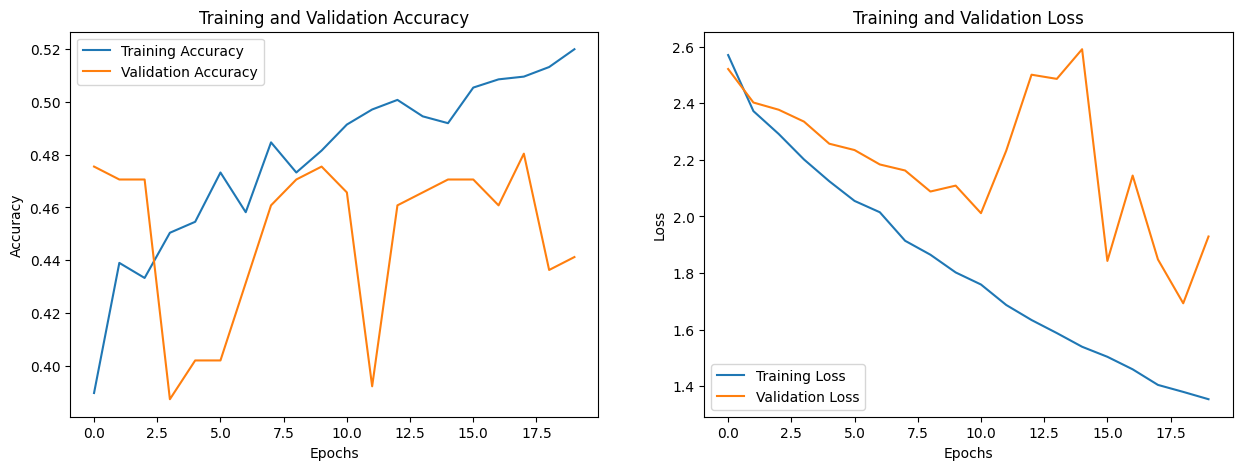

Found 117 images belonging to 4 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4288 - loss: 1.6960
Test Loss: 1.7641948461532593
Test Accuracy: 0.4444444477558136
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


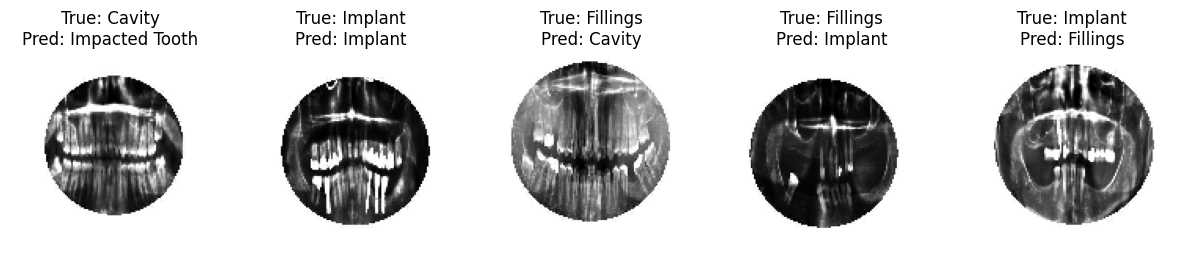

In [15]:
# Add necessary imports
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
# Get number of classes
num_classes = train_generator.num_classes

# Step 3: Create Improved Model - Fine-tune ResNet50 with L2 Regularization, Dropout, and BatchNormalization
def create_improved_model(input_shape=(128, 128, 3), num_classes=num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Fine-tune the last few layers of ResNet50 (reduce the number of layers being fine-tuned)
    for layer in base_model.layers[-10:]:  # Unfreeze the last 10 layers (reduced from 20)
        layer.trainable = True

    # Adding layers on top of the base model
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)  # Reduced from 128 to 64 units
    x = Dropout(0.3)(x)  # Reduced dropout rate
    output = Dense(num_classes, activation='softmax')(x)  # Output layer for classification

    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model with Adam optimizer and a fixed learning rate
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Step 4: Train and Evaluate the Model
def train_and_evaluate(model, train_generator, val_generator, epochs=5):  # Increase epochs to 20
    # Training the model
    history = model.fit(train_generator,
                        epochs=epochs,
                        validation_data=val_generator)

    # Plot Training & Validation Accuracy and Loss
    plot_training_history(history)

    # Evaluate on Test Data
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(test_dir, target_size=(128, 128), batch_size=32, class_mode='categorical')

    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    # Step 5: Visualize Predictions
    visualize_predictions(model, test_generator)

# Step 5: Visualize Predictions and Real Images
def visualize_predictions(model, test_generator, num_images=5):
    # Get a batch of images from the test set
    images, labels = next(test_generator)

    # Make predictions
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)

    # Get the class names from the generator's class_indices attribute
    class_names = list(test_generator.class_indices.keys())

    # Plot the images with their true and predicted labels
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i+1)
        ax.imshow(images[i])  # Display the image
        ax.set_title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
        ax.axis('off')
    plt.show()

# Step 6: Plot Training History
def plot_training_history(history):
    # Plot Training & Validation Accuracy and Loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()


# Step 7: Train the Model with Reduced Layers
model = create_improved_model()
print("Training Improved Model...")
train_and_evaluate(model, train_generator, valid_generator, epochs=20)  # Training for 20 epochs